In [1]:
import os
import gc
import cv2
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, ParameterGrid

import tensorflow as tf
import tensorflow.keras as keras
from keras.layers import *
from keras.optimizers import *
from keras.models import Sequential, Model
from keras.utils import to_categorical, plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint

import time
from tqdm import tqdm

In [2]:
HEIGHT, WIDTH = 64, 64
SEQUENCE_LENGTH = 20
SKIP_LENGTH = 20
CLASSES = ['frontraise', 'pullups', 'squant', 'front_raise', 'bench_pressing',
       'jump_jack', 'situp', 'benchpressing', 'squat', 'pull_up',
       'push_up', 'jumpjacks', 'pushups', 'others', 'battle_rope',
       'pommelhorse']
CLASSES_INDEX = dict(zip(CLASSES, range(len(CLASSES))))
CLASSES_INDEX_REVERSE = dict(zip(range(len(CLASSES)), CLASSES))

def frame_extraction(video_path):
    frames = []
    optical_flow_frames = []
    video_renderer = cv2.VideoCapture(video_path)
    video_frames_count = int(video_renderer.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    
    prev_gray = None
    
    for frame_counter in range(SEQUENCE_LENGTH):
        video_renderer.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_renderer.read()
        if not success:
            break
        frame = cv2.resize(frame, (HEIGHT, WIDTH))
        normalized_frame = frame / 255.0
        frames.append(normalized_frame)
        
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if prev_gray is None:
            prev_gray = gray
        
        flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        optical_flow_img = np.dstack((magnitude, angle))
        normalized_optical_flow_img = optical_flow_img / np.amax(optical_flow_img)
        optical_flow_frames.append(normalized_optical_flow_img)
        
        prev_gray = gray
        
    video_renderer.release()
    return frames, optical_flow_frames
    
def create_dataset():
    features = []
    features_optical_flow = []
    labels = []
    video_file_paths = []
    
    df = pd.read_csv('dataset.csv')
    for file_path, label in tqdm(zip(df['video_path'], df['label']), total=len(df)):
        frames, frames_optical_flow = frame_extraction(file_path)
        
        if len(frames) == SEQUENCE_LENGTH:
            video_file_paths.append(file_path)
            features.append(frames)
            features_optical_flow.append(frames_optical_flow)
            labels.append(CLASSES_INDEX[label])
        
    features = np.asarray(features)
    features_optical_flow = np.asarray(features_optical_flow)
    labels = np.array(labels)
    return features, features_optical_flow, labels, video_file_paths

features, features_optical_flow, labels, video_file_paths = create_dataset()

In [3]:
one_hot_encoded_labels = to_categorical(labels)

In [4]:
features_train, features_test, labels_train, labels_test = train_test_split(
    features, one_hot_encoded_labels, test_size = 0.2, random_state = 42, shuffle=True
)

features_optical_flow_train, features_optical_flow_test, labels_optical_flow_train, labels_optical_flow_test = train_test_split(
    features_optical_flow, one_hot_encoded_labels, test_size = 0.2, random_state = 42, shuffle=True
)

In [5]:
feature_inp = Input(shape=(SEQUENCE_LENGTH, HEIGHT, WIDTH, 3))

x = TimeDistributed(Conv2D(16, (3, 3), activation = 'relu', padding='same'))(feature_inp)
x = TimeDistributed(MaxPooling2D((4, 4)))(x)
x = TimeDistributed(Dropout(.2))(x)

x = TimeDistributed(Conv2D(32, (3, 3), activation = 'relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D((4, 4)))(x)
x = TimeDistributed(Dropout(.2))(x)

x = TimeDistributed(Conv2D(64, (3, 3), activation = 'relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Dropout(.2))(x)

x = TimeDistributed(Conv2D(128, (3, 3), activation = 'relu', padding='same'))(x)
x = TimeDistributed(MaxPooling2D((2, 2)))(x)
x = TimeDistributed(Dropout(.2))(x)

optical_flow_inp = Input(shape=(SEQUENCE_LENGTH, HEIGHT, WIDTH, 2))

x_opt = TimeDistributed(Conv2D(16, (3, 3), activation = 'relu', padding='same'))(optical_flow_inp)
x_opt = TimeDistributed(MaxPooling2D((4, 4)))(x_opt)
x_opt = TimeDistributed(Dropout(.2))(x_opt)

x_opt = TimeDistributed(Conv2D(32, (3, 3), activation = 'relu', padding='same'))(x_opt)
x_opt = TimeDistributed(MaxPooling2D((4, 4)))(x_opt)
x_opt = TimeDistributed(Dropout(.2))(x_opt)

x_opt = TimeDistributed(Conv2D(64, (3, 3), activation = 'relu', padding='same'))(x_opt)
x_opt = TimeDistributed(MaxPooling2D((2, 2)))(x_opt)
x_opt = TimeDistributed(Dropout(.2))(x_opt)

x_opt = TimeDistributed(Conv2D(128, (3, 3), activation = 'relu', padding='same'))(x_opt)
x_opt = TimeDistributed(MaxPooling2D((2, 2)))(x_opt)
x_opt = TimeDistributed(Dropout(.2))(x_opt)

x = concatenate([x, x_opt])

x = TimeDistributed(Flatten())(x)

x = LSTM(128)(x)

x = Dense(len(CLASSES), activation = 'softmax')(x)

model = Model([feature_inp, optical_flow_inp], x)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 20, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 input_2 (InputLayer)           [(None, 20, 64, 64,  0           []                               
                                 2)]                                                              
                                                                                                  
 time_distributed (TimeDistribu  (None, 20, 64, 64,   448        ['input_1[0][0]']                
 ted)                           16)                                                           

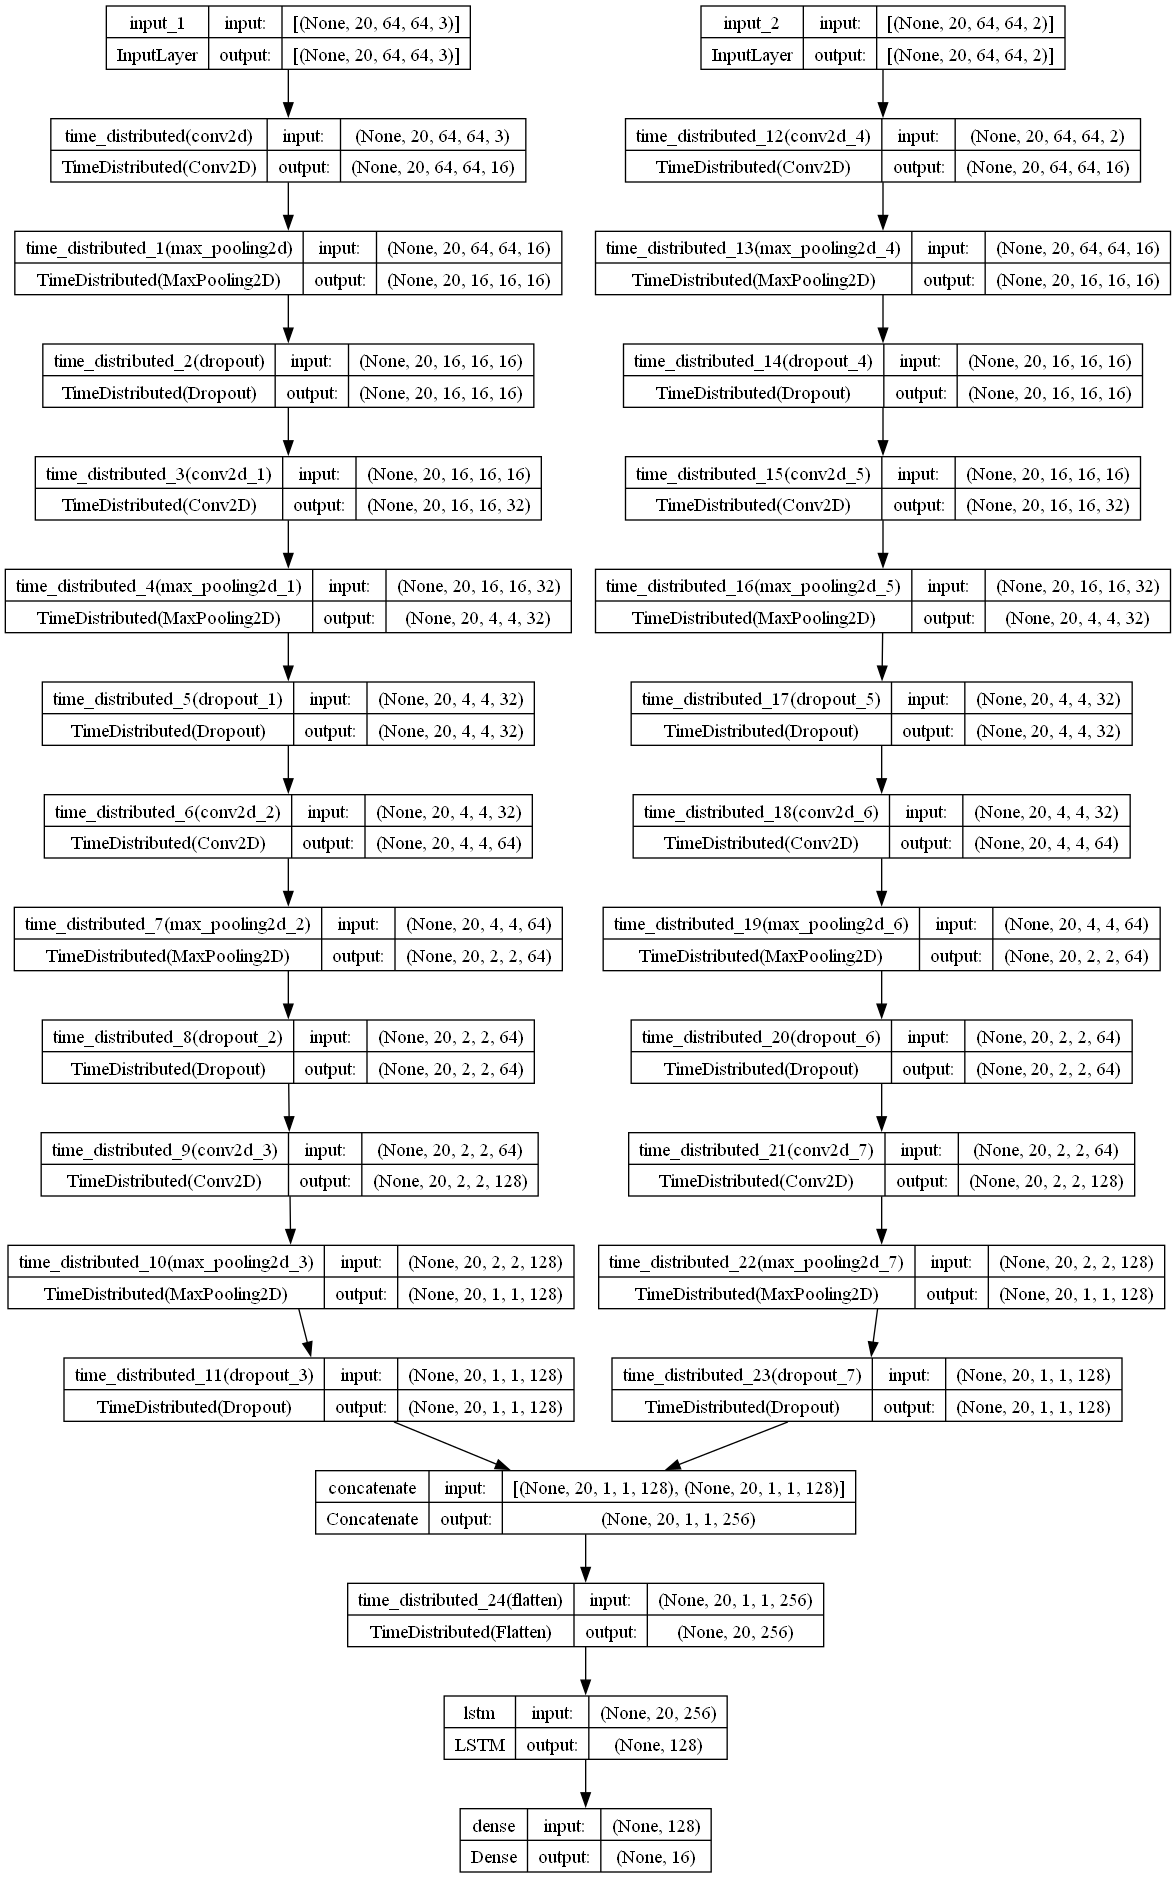

In [6]:
plot_model(model, show_shapes=True)

In [ ]:
# We are making hyper parameter tuning on a subset of dataset
features_train_subset, _, labels_train_subset, _ = train_test_split(
    features, one_hot_encoded_labels, test_size = 0.8, random_state = 42, shuffle=True
)

features_optical_flow_train_subset, _, labels_optical_flow_train_subset, _ = train_test_split(
    features_optical_flow, one_hot_encoded_labels, test_size = 0.8, random_state = 42, shuffle=True
)

param_grid = {
    'learning_rate': [1e-3, 1e-5, 1e-7], 
    'batch_size': [4, 8, 16],
    'Optimizer': [Adam, RMSprop, SGD]
}

param_combs = list(ParameterGrid(param_grid))
run_times = []
res = []

early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

for params in param_combs:
    model = Model([feature_inp, optical_flow_inp], x)
    
    start_time = time.time()
    
    lr = params['learning_rate']
    batch_size = params['batch_size']
    optimizer = params['Optimizer']
    
    if optimizer == Adam:
        opt_str = 'Adam'
    elif optimizer == RMSprop:
        opt_str = 'RMSprop'
    elif optimizer == SGD:
        opt_str = 'SGD'
    
    model.compile(optimizer = optimizer(learning_rate=lr), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    history = model.fit(x = [features_train_subset, features_optical_flow_train_subset], y = labels_train_subset, 
                        epochs = 20, batch_size = batch_size, shuffle = True, validation_split=.2, verbose=0, 
                        callbacks=[early_stopping])
    
    end_time = time.time()
    run_time = end_time - start_time
    
    run_times.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'optimizer': optimizer,
        'run_time': run_time
    })
    
    results = history.history
    res.append({
        'learning_rate': lr,
        'batch_size': batch_size,
        'optimizer': opt_str,
        'train_loss': results['loss'],
        'train_accuracy': results['accuracy'],
        'val_loss': results['val_loss'],
        'val_accuracy': results['val_accuracy'],
        'run_time': run_time
    })
    
    # Memory Cleanup
    del model
    gc.collect()
    time.sleep(10)

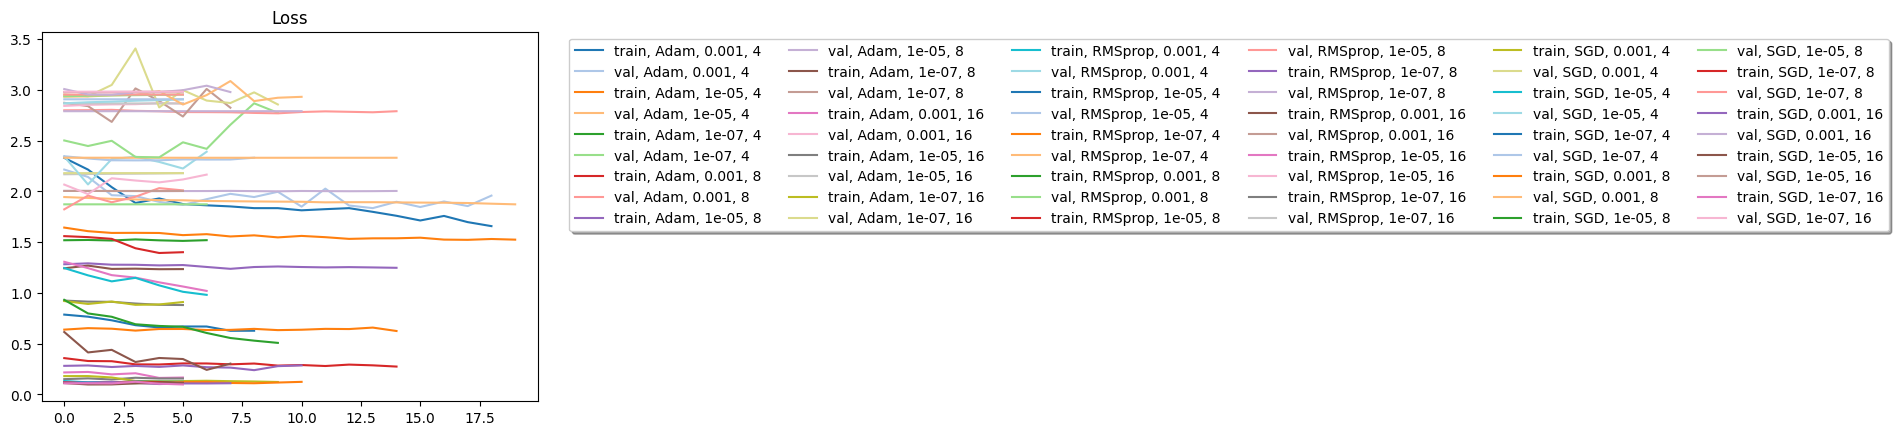

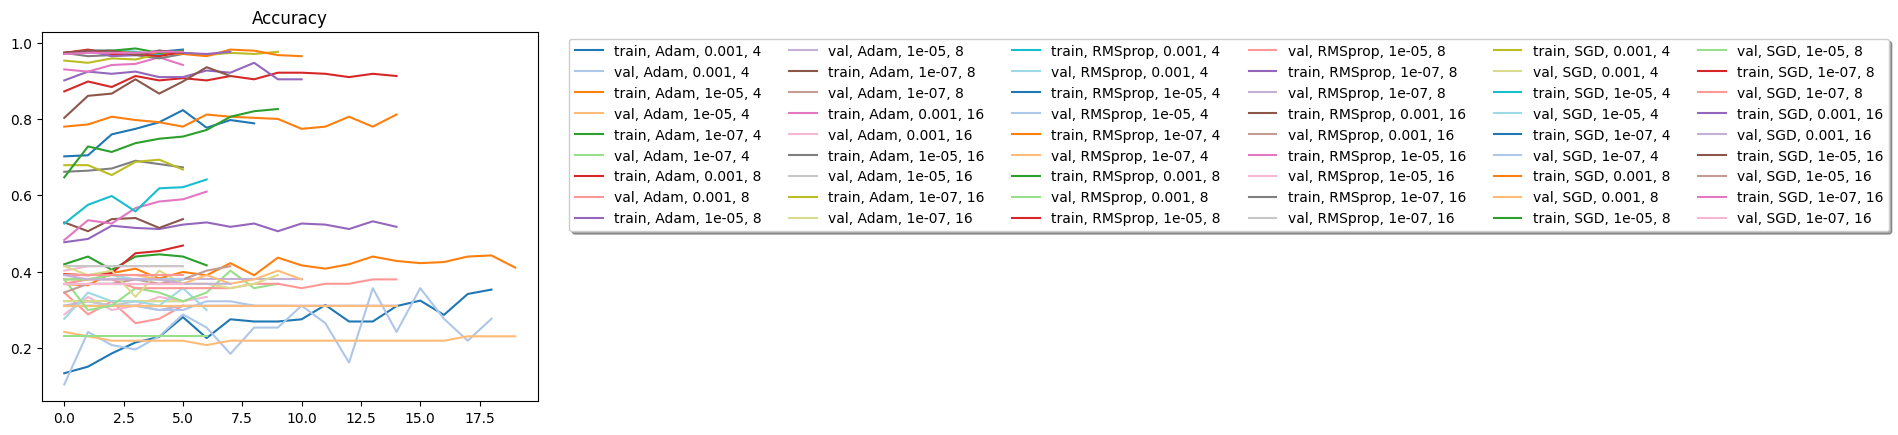

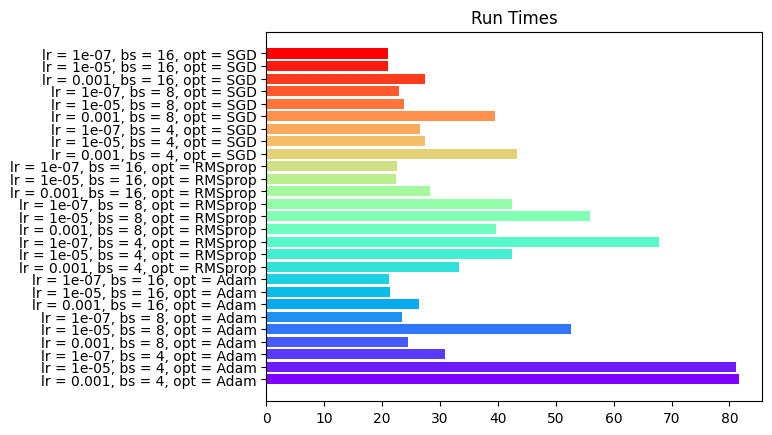

In [40]:
for i, r in enumerate(res):
    plt.plot(r['train_loss'], label = f'train, {r["optimizer"]}, {r["learning_rate"]}, {r["batch_size"]}', 
             color=plt.cm.tab20((2 * i) % plt.cm.tab20.N))
    plt.plot(r['val_loss'], label = f'val, {r["optimizer"]}, {r["learning_rate"]}, {r["batch_size"]}',
             color=plt.cm.tab20((2 * i + 1) % plt.cm.tab20.N))

plt.title('Loss')
plt.legend(bbox_to_anchor=(1.05, 1), ncols=6, fancybox=True, shadow=True)
plt.show()

for i, r in enumerate(res):
    plt.plot(r['train_accuracy'], label = f'train, {r["optimizer"]}, {r["learning_rate"]}, {r["batch_size"]}',
             color=plt.cm.tab20((2 * i) % plt.cm.tab20.N))
    plt.plot(r['val_accuracy'], label = f'val, {r["optimizer"]}, {r["learning_rate"]}, {r["batch_size"]}', 
             color=plt.cm.tab20((2 * i + 1) % plt.cm.tab20.N))
    
plt.title('Accuracy')
plt.legend(bbox_to_anchor=(1.05, 1), ncols=6, fancybox=True, shadow=True)
plt.show()

plt.barh([f'lr = {r["learning_rate"]}, bs = {r["batch_size"]}, opt = {r["optimizer"]}' for r in res], [r['run_time'] for r in res],
         color=plt.get_cmap('rainbow')(np.linspace(0, 1, len(res))))
plt.title('Run Times')
plt.show()

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
save_best_model = ModelCheckpoint('classification_model.h5', verbose=1, save_best_only=True, monitor='val_loss')

model.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(x = [features_train, features_optical_flow_train], y = labels_train, 
                    epochs = 100, batch_size = 16, shuffle = True, validation_split=.2, 
                    callbacks=[early_stopping, save_best_model])

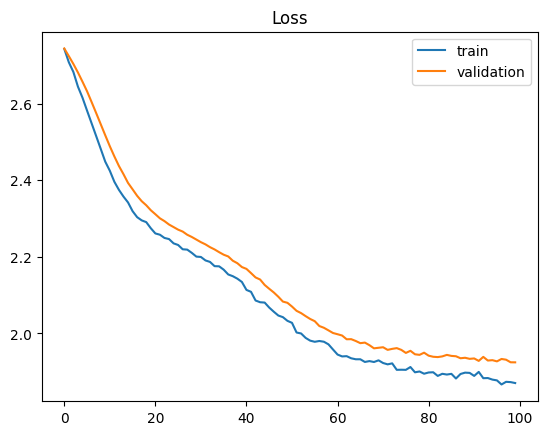

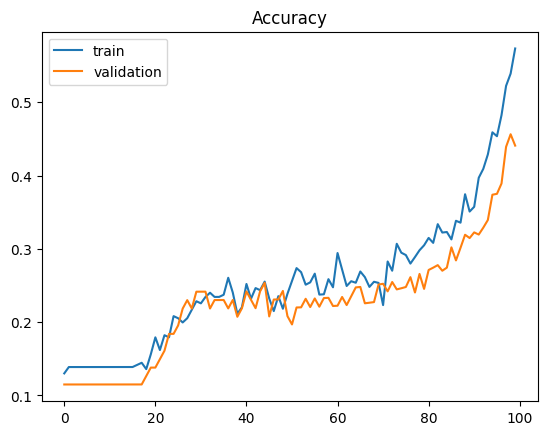

1.8701279163360596
1.9242349863052368
0.5734531900681228
0.44090553721721726


In [63]:
hist = history.history
plt.plot(hist['loss'], label = 'train')
plt.plot(hist['val_loss'], label = 'validation')
plt.title('Loss')
plt.legend()
plt.show()

plt.plot(hist['accuracy'], label = 'train')
plt.plot(hist['val_accuracy'], label = 'validation')
plt.title('Accuracy')
plt.legend()
plt.show()

print(hist['loss'][-1])
print(hist['val_loss'][-1])

print(hist['accuracy'][-1])
print(hist['val_accuracy'][-1])